# Elastic Search Indexing




## Inspirations

https://qbox.io/blog/building-an-elasticsearch-index-with-python
notebook from Marijn Koolen

In [2]:
# Run this cell to import the necessary libraries and initiate an Elasticsearch object.
import unicodecsv
import os
from elasticsearch import Elasticsearch
from elasticsearch.exceptions import RequestError
import datetime

import json
from IPython.core.display import display, HTML
import re

es = Elasticsearch(timeout=30, max_retries=10, retry_on_timeout=True) 
# parameters from https://stackoverflow.com/questions/25908484/how-to-fix-read-timed-out-in-elasticsearch

index = "migrants"

ImportError: No module named 'unicodecsv'

In [ ]:
def query(index, query):
    """wrapping up arcane elasticsearch results for program reuse
    Kicked out all es metadata for starts
    """
    result = es.search(index=index, body={"query": query})
    res = [hit['_source']  for hit in result['hits']['hits']]
    return res

# query tests

In [ ]:
# query persoonnaam

def make_query(personname):
    return {"query":
             {"bool":
              {"must":
               [{"fuzzy":{"prs_achternaam":
                          {"value": personname,"max_expansions":"2"}
                         }}
               ],
               "must_not":[],
               "should":[]
              }
             },
             "from":0,
             "size":10,
             "aggs":{}}

q = make_query('Jansen')

print q

es.search(index, body=q)

## query for a parent

## and for children

In [ ]:
def make_parent_query(childtype, childfield, name):
    return {
      "query": {
        "has_child": {
          "type": childtype,
          "query": {
            "term": {
              childfield: name
            }
          }
        }
      }
    }

q = make_parent_query('image', 'ocr', '1000')
print q
es.search(index, body=q)



In [ ]:
q = {"query":
        {"bool":
         {"must":
              [{"range":
                {"locr":
                 {"gt":"1000","lt":"2000"}
                }
               }],
                "must_not":[],
                "should":[]}},
        "from":0,
        "size":250,
        "sort":"locr",
        "aggs":{}
    }
    
result = es.search(index, body=q)
hits = [hit['_source']  for hit in result['hits']['hits']]
print (hits)

In [ ]:

#with aggegations
q = {"query":
        {"bool":
         {"must":
              [],
                "must_not":[],
                "should":[]}},
        "from":0,
        "size":250,
        "sort":"edges",
        "aggs" : {
            "sizes" : {
            "histogram" : {
                "field" : "edges",
                "interval" : 250
                }
            }
         }
      }
    
result = es.search(index, body=q)
hits = [hit['_source']  for hit in result['hits']['hits']]
hist = (result['aggregations']['sizes'])
for size in hist['buckets']:
    print (size)
    



In [ ]:

#with aggegations
q = {"query":
        {"bool":
         {"must":
              [{"range":
                {"aankomst":
                 {"gt":"1950-01-01","lt":"1955-01-01"}
                }
               }],
                "must_not":[],
                "should":[]}},
        "from":0,
        "size":250,
        "sort":"edges",
        "aggs" : {
            "sizes" : {
            "histogram" : {
                "field" : "edges",
                "interval" : 250
                }
            }
         }
      }
    
result = es.search(index, body=q)
print(result)
hits = [hit['_source']  for hit in result['hits']['hits']]
hist = (result['aggregations']['sizes'])
for size in hist['buckets']:
    print (size)

In [ ]:
## aggregates
index = "migrants"

q = {
    "query" : {
        "match" : {
            "last_name" : "Jansen"
        }
    },
    

        }

result = es.search(index, body=q)

print(result)

In [ ]:
def make_parent_query(childtype, childfield, name):
    return {
      "query": {
        "has_child": {
          "type": childtype,
          "query": {
            "term": {
              childfield: name
            }
          }
                
        }
      }
    }
    


q = make_parent_query('image', 'edges', '1000')
print q
es.search(index, body=q)

In [ ]:
# and the same with inner hits

def make_parent_query(childtype, childfield, name):
    return {
      "query": {
        "has_child": {
          "type": childtype,
          "query": {
            "term": {
              childfield: name
            }
          },
          "inner_hits": {}
                
        }
      }
    }
q = make_parent_query('image', 'edges', '1000')
print q
res = es.search(index, body=q)
#print res
hits = res['hits']['hits']
for item in hits:
#    for f in item['_source']:
#        print f, ": ", item['_source'][f]
    print '%s - %s : %s' % (item['_source']['prs_achternaam'], item['_source']['vertrek'], item['_source']['aankomst']) 
        

In [ ]:
q= {
  "aggs": {
    "range": {
      "date_range": {
        "field": "aankomst",
        "ranges": [
          {"from": "1945-01-01"},
          {"to": "1950-12-31"}
        ]
      }
    }
  }
}

print q
result = es.search(index, body=q)
print result['aggregations']['range']['buckets']
result['aggregations']['range']['buckets'][0]


In [ ]:
#with aggegations
q = {"aggs" : {
            "sizes" : {
            "date_histogram" : {
                "field" : "aankomst",
                "interval": "year",
                "min_doc_count": 10
                }
            }
         }
      }
     
    
result = es.search(index, body=q)
hits = [hit['_source']  for hit in result['hits']['hits']]
hist = (result['aggregations']['sizes'])
for size in hist['buckets']:
    print (size)

In [ ]:
q = {
    "aggs" : {
        "date_ranges" : {
            "range" : {
                "field" : "aankomst",
                "format":"yyyy",
                "keyed": "True",
                "ranges" : [
                    { "key": "laat", "to" : "1960" },
                    { "key": "midden", "from" : "1950", "to" : "1955" },
                    { "key" : "vroeg", "from" : "1945" }
                ]
            }
        }
    }
}

result = es.search(index, body=q)
hits = [hit['_source']  for hit in result['hits']['hits']]
hist = result['aggregations']
print hist

In [ ]:
q= {'query': 
    {'has_child': 
     {'query': 
      {'term': 
       {'edges': '1000'}
      }, 
      'inner_hits': {}, 
      'type': 'image'
     }
    }
   }

result = es.search(index, body=q)
hits = [hit['_source']  for hit in result['hits']['hits']]
print result

In [ ]:
imag = {"aggs": 
        {
        "densities":
            {"histogram":
                 {"field": "edges",
                  "interval": 250}
                }
        }
    }

dates =  {
    "aggs" : {
        "date_ranges" : {
            "range" : {
                "field" : "aankomst",
                "format":"yyyy",
                "keyed": "True",
                "ranges" : [
                    { "key": "laat", "to" : "1960" },
                    { "key": "midden", "from" : "1950", "to" : "1955" },
                    { "key" : "vroeg", "from" : "1945" }
                ], 
            }
        },

            }

    }

q = imag

result = es.search(index, body=q)
hits = [hit['_source']  for hit in result['hits']['hits']]
hist = result['aggregations']['densities']['buckets']
for i in hist:
    print i['key'], i['doc_count']

In [ ]:
q = {
  "size": 0,
  "aggs": {
    "edges": {
      "nested": {"path": "image"},
      "aggs": {
        "images": {
          "terms": {"field": "aankomst"},
          "aggs": {
            "categories": {
              "reverse_nested": {},
                    "aggs" : {
                        "date_ranges" : {
                            "range" : {
                                "field" : "aankomst",
                                "format":"yyyy",
                                "keyed": "True",
                                "ranges" : [
                                    { "key": "laat", "to" : "1960" },
                                    { "key": "midden", "from" : "1950", "to" : "1955" },
                                    { "key" : "vroeg", "from" : "1945" }
                                ], 
                            }
                        },


              }
            }
          }
        }
      }
    }
  }
}
result = es.search(index, body=q)

print(result)


#with aggegations
q = {"aggs" : {
            "sizes" : {
            "date_histogram" : {
                "field" : "aankomst",
                "interval": "year",
                "min_doc_count": 10
                }
            },
            "aggs": {
                "imgs": {
                  "children": {"type" : "image"}
                            }
                    },
         }
      }
     
    
result = es.search(index, body=q)
hits = [hit['_source']  for hit in result['hits']['hits']]
hist = (result['aggregations']['sizes'])
for size in hist['buckets']:
    print (size)

def make_parent_query(parenttype, parentfield, name):
    return {
      "query": {
        "has_parent": {
          "parent_type": parenttype,
          "query": {
            "parent": {
              parentfield: name
            }
          }
        }
      }
    }

q = make_parent_query('migrantunit', 'aankomst', '{"lt": "1951-01-01", "gt":"1950-01-01"}')
print q
res = es.search(index, body=q)
print "total results:", res['hits']['total']
for hit in res['hits']['hits'][:5]:
    print hit['_source']

# Period querying

In [ ]:
#query for period

q = {
    "size" : 10000,
    "query": {
        "has_parent" : {
            "parent_type" : "migrantunit",
            "query" : {
                "range" : {
                    "aankomst" : {"lt": "1951-01-01", "gt":"1950-01-01"}
                }            
            },
            "inner_hits":{},
        }
    }
}


#abstracted
def make_period_query(size=0, begin=1950, end=1951):
    """size gives number of results default is 10, 0 is without limit
    begin is beginning of period, end is end of period"""
    lt = "%s-01-01" % end
    gt = "%s-01-01" % begin
    q = {
            "size" : size,
            "query": {
                "has_parent" : {
                    "parent_type" : "migrantunit",
                    "query" : {
                        "range" : {
                            "aankomst" : {"lt": lt, 
                                          "gt": gt }
                        }            
                    },
                    "inner_hits":{},
                }
            }
        }
    return q

print make_period_query(size=10, begin=1951, end=1952)

                                                                     


#print res1['hits']['hits'][0]['_source'].keys()

#assert(res1['hits']['total'] != res1['hits']['total'])
#for hit in res1['hits']['hits']:
#    print hit['_source']['edges'], hit['_source']['bak'],hit['_source']['kaart']#, hit['inner_hits']

#for hit in res2['hits']['hits']:
#    print hit['_source']['edges'], hit['_source']['bak'],hit['_source']['kaart']#, hit['inner_hits']    
    
#res = es.search(index, body=q)
#print "total results:", res['hits']['total']

#results = [[hit['_source']['edges'], hit['_source']['bak'],hit['_source']['kaart']] for hit in res['hits']['hits']]




In [ ]:
#check soundness of results
q1 = make_period_query(size=10, begin=1951, end=1952)
q2 = make_period_query(size=10, begin=1961, end=1962)
res1 = es.search(index, body=q1)
res2 = es.search(index, body=q2)

r1 = [i['_source']['url'] for i in res1['hits']['hits']]
r2 = [i['_source']['url'] for i in res2['hits']['hits']]

assert r1 != r2 #if this does not raise an error so results are different!

In [ ]:
#test with size=0 (get all results) and whole period
q = make_period_query(begin=1900, end=2000, size=0)
result = es.search(index, body=q)
print result

In [ ]:
# query for empty years

q = {
    "size" : 10000,
    "query": {
        "has_parent" : {
            "parent_type" : "migrantunit",
            "query" : {
                "term" : {"aankomst" : "0000-00-00"}
                }
            }
        }
    }

result = es.search(index, body=q)
print result



# query for models

In [ ]:
# simple term query

#model
q1 = {"query": {
    "term" : { "ocr" : "model" }
    }
     }

res1 = es.search(index, body=q1)


#  model 162
q2 = {"query": {
        "simple_query_string" : {
                    "fields" : ["ocr",],
                    "query" : "model 162",
                    }
                }
         }

res2 = es.search(index, body=q2)


#162 (with trailing spaces)
q3 = {"query": {
    "term" : { "ocr" : "162" }
    }
     }

res3 = es.search(index, body=q3)

print ("total results 'model' vs 'model 162' vs '162':", res1['hits']['total'], res2['hits']['total'], res3['hits']['total'])

In [ ]:
#  model 162
q2 = {"size":1000, "from": 0,
    "query": {
        "simple_query_string" : {
                    "fields" : ["ocr",],
                    "query" : "model 162",
                    }
                }
         }

res2 = es.search(index, body=q2)
print res2

In [ ]:
def q_term(text, size=10, index='migrants', search_after=None):
    q = {"query": {
         "simple_query_string" : {
                      "fields" : ["ocr",],
                      "query" : text,
                      }
                  },
     "sort" : {"id.keyword" : "asc"}
     }
           
    if search_after:
           q["search_after"] = search_after

    res = es.search(index, body=q)
    return res

#tst
#q={'size': 10, 'from': 0, 'query': {'simple_query_string': {'fields': ['ocr'], 'query': 'model 162'}}}
#r = es.search(index, body=q)
#print (r)
result = q_term('model 162', size=10000)

number = result['hits']['total']
hits = [[hit['_source']['id'], hit['_source']['url'], hit['_source']['bak'],hit['_source']['kaart']] for hit in result['hits']['hits']]

while len(hits) < number:
    resume = [hits[-1][0]]
    result = q_term('model 162', size=10000, search_after=resume)
    nhits =[[hit['_source']['id'], hit['_source']['url'], hit['_source']['bak'],hit['_source']['kaart']] for hit in result['hits']['hits']]
    hits.extend(nhits)
    if result['hits']['total'] < 10000:
        break
        
print len(hits)
flname = "%s-%s.csv" % (begin, end)
flout = open(flname, 'w')
w = DictWriter(flout, fieldnames=['yr','edges', 'bak', 'kaart'])
result = result
for item in result:
    w.writerows(item)
flout.close()
print('%s written' % flname)
    
density2fl(1945, 1992, 1, result)




In [ ]:
def q_text(text, size, frm):
    r_len = 0 
    sz = size
    result = []
    models = q_term(text, size, frm)
    r_len = models['hits']['total']
    print (r_len)
    r =  [{'edges':hit['_source']['edges'], 
           'bak':hit['_source']['bak'],
           'kaart':hit['_source']['kaart']} for hit in models['hits']['hits']]
    result.extend(r)
    while sz < r_len:
        sz += size
        frm += sz + 1
        models = q_term(text, size, frm)
        r =  [{'edges':hit['_source']['edges'], 
                   'bak':hit['_source']['bak'],
                   'kaart':hit['_source']['kaart']} for hit in models['hits']['hits']]
        result.extend(r)
    return result

result = q_text('model 162', 10000, 0)
print (len(result), result[:100])

#this fail because the total search window is too large (i.e. > 10000)

In [ ]:
# query as child, but this will not work

q2 = {"query": {
        "match" : {
                    "ocr" : {
                        "query" : "model 162",
                        "operator" : "and"
                    }
                }
         }
      }


q_ch_hits = {
    "query": {
        "has_child" : {
            "type" : "images"
            }
    }
}


result = es.search(index, q_ch_hits)

"""                "query": {
                    "match" : {
                                "ocr" : {
                                    "query" : "model 162",
                                    "operator" : "and"
                                }
                            }
                     },"""

print (result)

# lets develop a tool to compare different periods

In [ ]:
#querytool

def density_from_res(query):
    res = es.search(index, body=query) 
    result = [{'edges':hit['_source']['edges'], 
               'bak':hit['_source']['bak'],
               'kaart':hit['_source']['kaart']} for hit in res['hits']['hits']]
    return result

q1 = make_period_query(size=10, begin=1950, end=1951)

print (result)

In [ ]:
#densitiy-tool
def range_densities(begin, end, interval):
    intervals = range(begin, end, interval)
    queries = []
    for i in intervals:
        r = density_from_res(make_period_query(size=10000, begin=i, end=i+interval))
        for e in r:
            e['yr'] = i
        queries.append(r)
    return queries

#test
rd = range_densities(1980, 1985, 2)
print (len(rd), type(rd))

In [ ]:
# and for average

def gem(rws):
    edg = [int(r['edges']) or 0 for r in rws]
    gm = sum(edg)/len(edg)
    return gm

def density_digested(begin, end, interval):
    result = {}
    input = range_densities(begin, end, interval)
    for item in input:
        g = gem(item)
        y = item[0]['yr']
        result[y] = g
    return result

#test
densities = density_digested(1945, 1992, 1)
print (densities)
    

# Plotting

plot density distribution and average densities

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = [i['doc_count'] for i in hist]
y_pos = np.arange(len(objects))
densities = [int(i['key']) for i in hist]
densities.sort()

 
plt.bar(y_pos, objects, align='center', alpha=0.5)
plt.xticks(rotation=70)
plt.xticks(y_pos, densities)
plt.ylabel('nr of cards')
plt.xlabel('density')
plt.title('densities distribution emigrant cards')


 
plt.show()

This chart shows the distribution of the densities over the complete file of images. Many of the empty cards may be accounted for by establishing that they are the back of cards. As usual, the most densely written cards are a minority. Furthermore, many of the cards contain some pre-printed stuff, both lines and text, that will account for the less densely printed cards. The cards with a lot of information are a minority. It is not possible to provide a more detailed analysis of the cards on basis of this distribution alone. A threshold of where information density becomes important has to be established with further research.

<IPython.core.display.Javascript object>


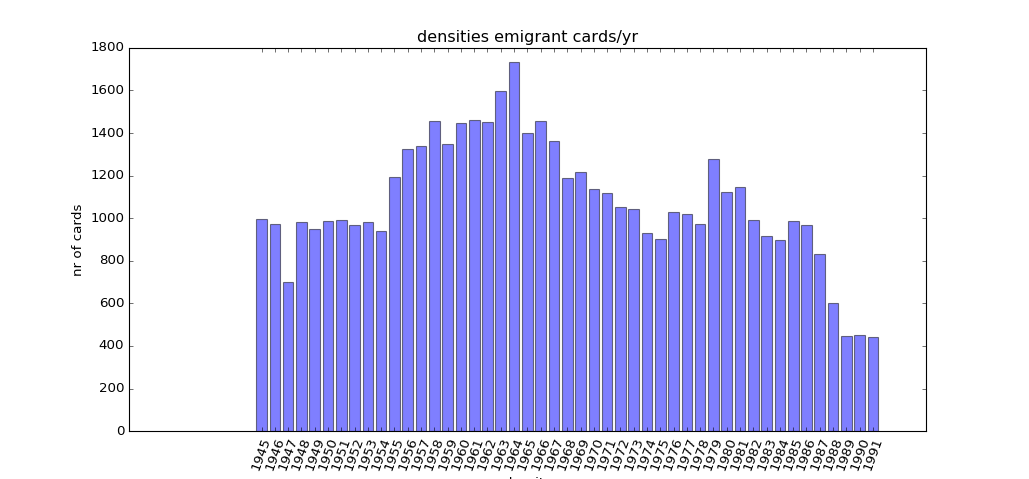

In [125]:
%matplotlib notebook
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = densities.values()
y_pos = np.arange(len(objects))
yrs = densities.keys()
yrs.sort()

 
plt.bar(y_pos, densities.values(), align='center', alpha=0.5)
plt.xticks(rotation=70)
plt.xticks(y_pos, yrs)
plt.xlabel('years')
plt.ylabel('density')
plt.title('densities emigrant cards/yr')


 
plt.show()


The figure above gives the distribution of card density over time. Card density is lower in the beginning, and grows from the middle of the 1950s and decreases after the mid-1960s until there is another increase around 1980. The changes in the average density over time roughly reflect the changes in the number of migrants, but as these are average densities, they are not directly related to them.

Further interpretation depends on more detailed research; obvious hypotheses are:

- the initial increase from the mid-1950s was related to more intensive support from the consulates
- stimulating emigration resulted in the departure of migrants that needed more support (because they were ill-prepared or less fit for migration)

# Write to csv file

In [28]:
# first export to csv
import csv

print q
res = es.search(index, body=q)
print "total results:", res['hits']['total']

results = [[hit['_source']['edges'], hit['_source']['bak'],hit['_source']['kaart']] for hit in res['hits']['hits']]

flout = open('tstres.csv', 'w')

w = csv.writer(flout)
w.writerows(results)
flout.close()
#print res['hits']['hits']


#for hit in res['hits']['hits']:
#    print hit['_source']['edges'], hit['_source']['bak'],hit['_source']['kaart'], hit['inner_hits']

{'query': {'has_parent': {'query': {'range': {'aankomst': {'lt': '2000-01-01', 'gt': '1900-01-01'}}}, 'inner_hits': {}, 'parent_type': 'migrantunit'}}, 'size': 0}
total results: 49914


In [49]:
from csv import DictWriter



def density2fl(begin, end, interval):
    flname = "%s-%s.csv" % (begin, end)
    flout = open(flname, 'w')
    w = DictWriter(flout, fieldnames=['yr','edges', 'bak', 'kaart'])
    result = range_densities(begin, end, interval)
    for item in result:
        w.writerows(item)
    flout.close()
    print('%s written' % flname)
    
density2fl(1945, 1992, 1)

1945-1992.csv written


In [55]:
#and write summary csv

begin = 1945
end = 1992
interval = 1


flname = "%s-%s_summary.csv" % (begin, end)
flout = open(flname, 'w')
w = DictWriter(flout, fieldnames=['yr','edges'])
result = density_digested(begin, end, interval)
w.writerows([{'yr':i[0], 'edges':i[1]} for i in result.items()])
flout.close()
print('%s written' % flname)

1945-1992_summary.csv written


## some d3 trials (not very succesful)

In [29]:
from IPython.core.display import display, HTML
from string import Template
import json

HTML('HELLO DOM')

In [30]:
HTML('<script src="lib/d3/d3.min.js"></script>')

In [31]:
html_template = Template('''
<style> $css_text </style>
<div id="graph-div"></div>
<script> $js_text </script>
''')

In [32]:
css_text = '''

.bar {
  fill: steelblue;
}

.bar:hover {
  fill: brown;
}

.axis {
  font: 10px sans-serif;
}

.axis path,
.axis line {
  fill: none;
  stroke: #000;
  shape-rendering: crispEdges;
}

.x.axis path {
  display: none;
}

'''

In [33]:
js_text_template = Template('''

var margin = {top: 20, right: 20, bottom: 30, left: 40},
    width = 500 - margin.left - margin.right,
    height = 300 - margin.top - margin.bottom;

var x = d3.scale.ordinal()
    .rangeRoundBands([0, width], .1);

var y = d3.scale.linear()
    .range([height, 0]);

var xAxis = d3.svg.axis()
    .scale(x)
    .orient("bottom");

var yAxis = d3.svg.axis()
    .scale(y)
    .orient("left");

var svg = d3.select("#graph-div").append("svg")
    .attr("width", width + margin.left + margin.right)
    .attr("height", height + margin.top + margin.bottom)
  .append("g")
    .attr("transform", "translate(" + margin.left + "," + margin.top + ")");

var data = $data ;

  x.domain(data.map(function(d) { return d.letter; }));
  y.domain([0, d3.max(data, function(d) { return d.y; })]);

  svg.append("g")
      .attr("class", "x axis")
      .attr("transform", "translate(0," + height + ")")
      .call(xAxis);

  svg.append("g")
      .attr("class", "y axis")
      .call(yAxis);

  svg.selectAll(".bar")
      .data(data)
    .enter().append("rect")
      .attr("class", "bar")
      .attr("x", function(d) { return x(d.letter); })
      .attr("width", x.rangeBand())
      .attr("y", function(d) { return y(d.y); })
      .attr("height", function(d) { return height - y(d.y); });

''')



In [34]:
js_text_template_2 = Template('''

var bars = svg.selectAll(".bar").data($data);
  
bars
  .transition()
    .attr("y", function(d) { return y(d.y); })
    .attr("height", function(d) { return height - y(d.y); });

''')

In [35]:
js_text = js_text_template.substitute({'data': json.dumps(densities)})
HTML(html_template.substitute({'css_text': css_text, 'js_text': js_text}))

== cells with fails 


#with aggegations
q = {"query":
        {"bool":
         {"must":
              [],
                "must_not":[],
                "should":[]}},
        "from":0,
        "size":250,
        "sort":"edges",
        "aggs" : {
            "sizes" : {
            "histogram" : {
                "field" : "edges",
                "interval" : 250
                }
            }
         }
      }
    
result = es.search(index, body=q)
hits = [hit['_source']  for hit in result['hits']['hits']]
hist = (result['aggregations']['sizes'])
for size in hist['buckets']:
    print (size)